## 3.  Модели и отбор признаков

In [4]:
import os
import pandas as pd
import pickle
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (f1_score, 
                             fbeta_score,
                             roc_auc_score, 
                             precision_score, 
                             precision_recall_curve, 
                             confusion_matrix,
                             make_scorer
                            )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

%matplotlib inline
# warnings.filterwarnings('ignore')

In [28]:
def get_metrics(y_test, preds):
    
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    
    return roc_auc_score(y_test, preds), precision[ix], recall[ix], fscore[ix], thresholds[ix]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
with open('../parsed_data/X_train_all_feats_0.pickle', 'rb') as f:
    X_train = pickle.load(f)

- LR и RF на всех признаках c последующим удалением тесно связанных и ухудшающих метрики признаков
- всего 6 итераций отбора, 7 - ухудшает результат

In [9]:
# все признаки
cat_col = ['n_org_per_index_quant', 'region_code', 'n_org_per_region_code_quant', 'okved2_1', 'okopf', 'subj_cat',
              'new_subj_cat', 'change_subj_cat'
             ]

bin_col = ['is_soc_enterprise', 'newly_establ', 'is_high_tech', 'disqual_person', 'is_fin_sup'
          ]

num_col = ['n_org_per_index', 'n_org_per_index_q95', 'n_org_per_index_log', 'n_org_per_index_quant',
           
           'n_org_per_region_code', 'n_org_per_region_code_log', 'n_org_per_region_code_med', 'n_org_per_region_code_q95',
           'n_org_per_region_code_quant', 'target_fract_per_region',
           
           'n_org_per_okved2', 'n_org_per_okved2_med', 'n_org_per_okved2_q95', 'n_org_per_okved2_per_region', 
           'n_org_per_okved2_per_region_log', 'n_org_per_okved2_per_region_med', 'n_org_per_okved2_per_region_q95', 
           'n_org_per_okved2_per_locality', 'n_org_per_okved2_per_locality_med', 'n_org_per_okved2_per_locality_q95',
           
           'n_org_per_okopf', 'n_org_per_okopf_region', 'n_org_per_okopf_region_log', 'n_org_per_okopf_region_med', 
           'n_org_per_okopf_region_q95', 'n_org_per_okopf_locality', 'n_org_per_okopf_locality_med', 
           'n_org_per_okopf_locality_q95',
           
           'subj_cat', 'new_subj_cat', 'change_subj_cat_range',
           
           'from_registr_days', 'from_registr_days_log', 'from_registr_days_med', 'from_registr_days_q95', 'from_registr_days_fract',
           'from_registr_days_fract_med', 'from_registr_days_fract_q95',
           
           'from_inclusion_days', 'from_inclusion_days_med', 'from_inclusion_days_q95', 'from_inclusion_days_fract',
           'from_inclusion_days_fract_med', 'from_inclusion_days_fract_q95',
           
           'populations_med', 'populations_med_med', 'populations_med_q95', 'populations_region_med',
           'populations_region_med_med', 'populations_region_med_q95',
           
           'region_population',
           
           '2021_1150','2020_1150','2021_1170','2020_1170','2021_1210','2020_1210','2021_1230', '2020_1230', '2021_1250',
           '2020_1250','2021_1600','2020_1600', '2021_1350', '2020_1350', '2021_1360', '2020_1360', '2021_1300', 
           '2020_1300', '2021_1520', '2020_1520', '2021_1700', '2020_1700',
           '2021_1150_med', '2020_1150_med', '2021_1170_med', '2020_1170_med', '2021_1210_med', '2020_1210_med', 
           '2021_1230_med', '2020_1230_med', '2021_1250_med', '2020_1250_med', '2021_1600_med', '2020_1600_med', 
           '2021_1350_med', '2020_1350_med', '2021_1360_med', '2020_1360_med', '2021_1300_med', '2020_1300_med', 
           '2021_1520_med', '2020_1520_med', '2021_1700_med', '2020_1700_med',
           '2021_1150_q95', '2020_1150_q95', '2021_1170_q95', '2020_1170_q95', '2021_1210_q95', '2020_1210_q95', 
           '2021_1230_q95', '2020_1230_q95', '2021_1250_q95', '2020_1250_q95', '2021_1600_q95', '2020_1600_q95', 
           '2021_1350_q95', '2020_1350_q95', '2021_1360_q95', '2020_1360_q95', '2021_1300_q95', '2020_1300_q95', 
           '2021_1520_q95', '2020_1520_q95', '2021_1700_q95', '2020_1700_q95',
           '2020_1150_q95_growth', '2020_1170_growth', '2020_1210_q95_growth', '2020_1230_q95_growth', 
           '2020_1250_q95_growth', '2020_1600_q95_growth', '2020_1350_growth', '2020_1360_growth', '2020_1300_q95_growth', 
           '2020_1520_q95_growth', '2020_1700_q95_growth',
           
           '2021_2110', '2020_2110', '2021_2120', '2020_2120', '2021_2330', '2020_2330', '2021_2340', '2020_2340', 
           '2021_2350', '2020_2350', '2021_2410', '2020_2410', '2021_2400', '2020_2400', 
           '2021_2110_med', '2020_2110_med', '2021_2120_med', '2020_2120_med', '2021_2330_med', '2020_2330_med', 
           '2021_2340_med', '2020_2340_med', '2021_2350_med', '2020_2350_med', '2021_2410_med', '2020_2410_med', 
           '2021_2400_med', '2020_2400_med',
           '2021_2110_q95', '2020_2110_q95', '2021_2120_q95', '2020_2120_q95', '2021_2330_q95', '2020_2330_q95', 
           '2021_2340_q95', '2020_2340_q95', '2021_2350_q95', '2020_2350_q95', '2021_2410_q95', '2020_2410_q95', 
           '2021_2400_q95', '2020_2400_q95',
           '2020_2110_q95_growth', '2020_2120_q95_growth', '2020_2330_growth', '2020_2340_q95_growth', 
           '2020_2350_q95_growth', '2020_2410_q95_growth', '2020_2400_q95_growth', 
           
           '0102_2020', '0102_2021', '0103_2020', '0103_2021', '0105_2020', '0105_2021',
           '0102_2020_med', '0102_2021_med', '0103_2020_med', '0103_2021_med', '0105_2020_med', '0105_2021_med', 
           '0102_2020_q95', '0102_2021_q95', '0103_2020_q95', '0103_2021_q95', '0105_2020_q95', '0105_2021_q95',
           '0102_2020_log', '0102_2021_log', '0103_2020_log', '0103_2021_log', '0105_2020_log', '0105_2021_log',
           
           'arrears', 'penalties', 'fines', 'fine_amount',
           'arrears_med', 'penalties_med', 'fines_med', 'fine_amount_med',
           'arrears_q95', 'penalties_q95', 'fines_q95', 'fine_amount_q95',
           'arrears_log', 'penalties_log', 'fines_log', 'fine_amount_log', 
           'tax_arrears', 'tax_arrears_med', 'tax_arrears_q95', 'tax_arrears_log',
           'tax_arr_per_reg_okved', 'tax_arr_per_reg_okved_log',
           
           'cons_basket_child_2020', 'cons_basket_child_2021', 'cons_basket_pens_2020', 'cons_basket_pens_2021', 
           'cons_basket_working_age_2020', 'cons_basket_working_age_2021',
           'cons_basket_max', 'cons_basket_max_med', 'cons_basket_max_q95',
           
           'AI92_cost_2020', 'AI92_cost_2021', 'AI95_cost_2020', 'AI95_cost_2021', 'AI98_cost_2020', 'AI98_cost_2021', 
           'diesel_cost_2020', 'diesel_cost_2021',
           'AI92_cost_2020_med', 'AI92_cost_2021_med', 'AI95_cost_2020_med', 'AI95_cost_2021_med', 'AI98_cost_2020_med', 
           'AI98_cost_2021_med', 'diesel_cost_2020_med', 'diesel_cost_2021_med',
           'AI92_cost_2020_q95', 'AI92_cost_2021_q95', 'AI95_cost_2020_q95', 'AI95_cost_2021_q95', 'AI98_cost_2020_q95', 
           'AI98_cost_2021_q95', 'diesel_cost_2020_q95', 'diesel_cost_2021_q95', 
           'diesel_cost_quant',
           
           'AI92_volume_2020', 'AI92_volume_2021', 'AI95_volume_2020', 'AI95_volume_2021', 'AI98_volume_2020', 
           'AI98_volume_2021', 'diesel_volume_2020', 'diesel_volume_2021',
           'AI92_volume_2020_med', 'AI92_volume_2021_med', 'AI95_volume_2020_med', 'AI95_volume_2021_med', 
           'AI98_volume_2020_med', 'AI98_volume_2021_med', 'diesel_volume_2020_med', 'diesel_volume_2021_med',
           'AI92_volume_2020_q95', 'AI92_volume_2021_q95', 'AI95_volume_2020_q95', 'AI95_volume_2021_q95', 
           'AI98_volume_2020_q95', 'AI98_volume_2021_q95', 'diesel_volume_2020_q95', 'diesel_volume_2021_q95',
           'AI92_volume_2020_norm', 'AI92_volume_2021_norm', 'AI95_volume_2020_norm', 'AI95_volume_2021_norm', 
           'AI98_volume_2020_norm', 'AI98_volume_2021_norm', 'diesel_volume_2020_norm', 'diesel_volume_2021_norm',
           'AI92_volume_2020_norm_q95', 'AI92_volume_2021_norm_q95', 'AI95_volume_2020_norm_q95', 
           'AI95_volume_2021_norm_q95', 'AI98_volume_2020_norm_q95', 'AI98_volume_2021_norm_q95', 
           'diesel_volume_2020_norm_q95', 'diesel_volume_2021_norm_q95',
           'diesel_vol_quant',
           
           'cons_basket_max_q95_log', 'AI92_cost_2020_q95_log', 'AI92_cost_2021_q95_log', 'AI95_cost_2020_q95_log', 
           'AI95_cost_2021_q95_log', 'AI98_cost_2020_q95_log', 'AI98_cost_2021_q95_log', 'diesel_cost_2020_q95_log', 
           'diesel_cost_2021_q95_log', 'AI92_volume_2020_q95_log', 'AI92_volume_2021_q95_log', 'AI95_volume_2020_q95_log', 
           'AI95_volume_2021_q95_log', 'AI98_volume_2020_q95_log', 'AI98_volume_2021_q95_log', 
           'diesel_volume_2020_q95_log', 'diesel_volume_2021_q95_log',
           
           'n_contracts', 'n_agreements', 'n_okovd_add', 'n_licenses', 'n_products',
           'n_contracts_log', 'n_agreements_log', 'n_okovd_add_log', 'n_licenses_q95_log', 'n_products_log', 
           
           'n_employees', 'n_employees_1', 'n_employees_med', 'n_employees_q95', 'n_employees_q95_log', 'n_employees_quant'
          ]

In [53]:
X_train.shape

(936000, 370)

- стандартизиация для LR

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col])

In [11]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col)

In [22]:
X_train_scaled.head(3)

,n_org_per_index,n_org_per_index_q95,n_org_per_index_log,n_org_per_index_quant,n_org_per_region_code,n_org_per_region_code_log,n_org_per_region_code_med,n_org_per_region_code_q95,n_org_per_region_code_quant,target_fract_per_region,...,n_agreements_log,n_okovd_add_log,n_licenses_q95_log,n_products_log,n_employees,n_employees_1,n_employees_med,n_employees_q95,n_employees_q95_log,n_employees_quant
0,0.451459,0.645573,0.774289,0.872230,2.063572,1.559072,2.069518,2.063572,1.398968,-0.221965,...,-0.012275,1.746411,-0.38002,-0.022559,-0.267398,-0.274640,-0.493006,-0.596099,-0.537427,-0.639342
1,0.441171,0.632590,0.768897,0.872230,-0.151963,0.411363,-0.171573,-0.151963,0.731370,-1.126456,...,-0.012275,-0.518517,-0.38002,-0.022559,-0.267398,-0.274640,-0.493006,-0.596099,-0.537427,-0.639342
2,-0.253274,-0.243756,0.253033,0.176535,2.063572,1.559072,2.069518,2.063572,1.398968,-0.221965,...,-0.012275,0.428514,-0.38002,-0.022559,-0.162509,-0.170093,0.256678,-0.111874,0.305108,0.603312


- onehot

In [12]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [13]:
X_train_ohe = ohe.fit_transform(X_train[cat_col])

In [14]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names_out())

In [15]:
X_train_all_feat = pd.concat([X_train_ohe, X_train[bin_col], X_train_scaled], axis=1)

In [62]:
X_train_all_feat.shape

(936000, 576)

- **logistic regression**

In [64]:
lr = LogisticRegression(penalty='l1', C=0.9, class_weight='balanced', max_iter=100, 
                        random_state=42, solver='saga', verbose=1, n_jobs=-1)

- без saga и l1 считается около 4 минут и даёт roc_auc примерно 0.77
- l1-регуляризацией - от 20 до 30 мин

In [65]:
%%time
lr.fit(X_train_all_feat, X_train.target)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


max_iter reached after 1335 seconds


C:\Users\013\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 22.3min finished


Wall time: 22min 27s


LogisticRegression(C=0.9, class_weight='balanced', n_jobs=-1, penalty='l1',
                   random_state=42, solver='saga', verbose=1)

In [66]:
# with open('models/lr_all_feats.pickle', 'wb') as f:
#     pickle.dump(lr, f)

In [17]:
# with open('models/lr_all_feats.pickle', 'rb') as f:
#     lr = pickle.load(f)

In [67]:
lr_predict = lr.predict_proba(X_train_all_feat)[:, 1]

roc_auc, prec, rec, f_score, th = get_metrics(X_train.target, lr_predict)
print(f'roc_auc: {roc_auc:.4f}, prec: {prec:.4f}, rec: {rec:.4f},'
      f' f-score: {f_score:.4f}, th: {th:.4f}')

roc_auc: 0.7614, prec: 0.3735, rec: 0.1814, f-score: 0.2442, th: 0.8565


In [68]:
confusion_matrix(X_train.target, lr_predict > th)

array([[911863,   5630],
       [ 15151,   3356]], dtype=int64)

Confusion matrix, without normalization
[[911863   5630]
 [ 15151   3356]]


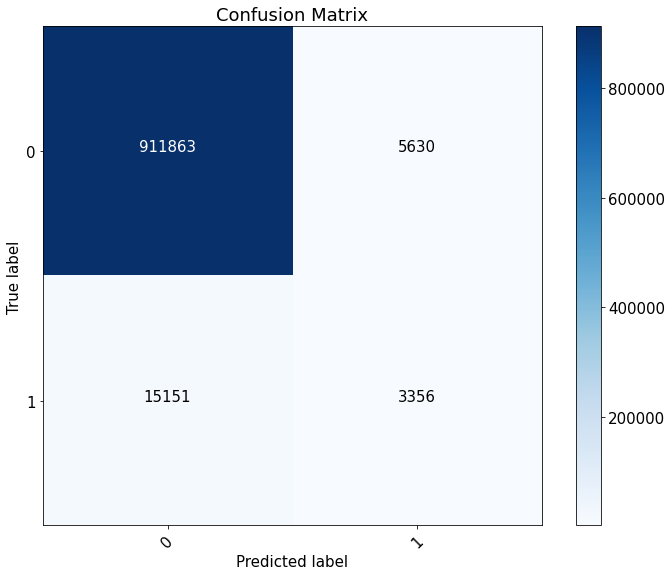

In [73]:
font = {'size': 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(X_train.target, lr_predict > th)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=[0, 1], title='Confusion Matrix')

- достаточно неплохая стартовая точка, чтобы использовать для предварительного отбора или как доп. фактор при оценке перспектив.
- дальше, если смотреть на важность признаков - надо больше поработать над финансовыми признаками.

- **random_forest**

In [43]:
rf = RandomForestClassifier(class_weight='balanced', oob_score=True, n_jobs=-1, random_state=True)

- сразу же сильно переобучается при стандартных гиперпараметрах

In [44]:
%%time
rf.fit(X_train_all_feat, X_train.target)

rf_predict = rf.predict_proba(X_train_all_feat)[:, 1]

roc_auc, prec, rec, f_score, th = get_metrics(X_train.target, rf_predict)
print(f'roc_auc: {roc_auc:.4f}, prec: {prec:.4f}, rec: {rec:.4f},'
      f' f-score: {f_score:.4f}, th: {th:.4f}')

roc_auc: 1.0000, prec: 0.9997, rec: 1.0000, f-score: 0.9999, th: 0.4500
Wall time: 7min 44s


- oob-оценка - больше похожа на правду

In [45]:
oob_pred_train = rf.oob_decision_function_[:, 1]

roc_auc, prec, rec, f_score, th = get_metrics(X_train.target, oob_pred_train)
print(f'roc_auc: {roc_auc:.4f}, prec: {prec:.4f}, rec: {rec:.4f},'
      f' f-score: {f_score:.4f}, th: {th:.4f}')

roc_auc: 0.7075, prec: 0.4340, rec: 0.1923, f-score: 0.2665, th: 0.1778


In [ ]:
# with open('models/rf_all_feats.pickle', 'wb') as f:
#     pickle.dump(rf, f)

In [17]:
# with open('../models/rf_all_feats.pickle', 'rb') as f:
#     rf = pickle.load(f)

In [ ]:
font = {'size': 15}

plt.rc('font', **font)

cnf_matrix_rf = confusion_matrix(X_train.target, oob_pred_train > th)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_rf, classes=[0, 1], title='Confusion Matrix')

- что у LR, что у RF - достаточно много пропусков (FN) - т.е. предсказание, что орагнизация не закроется в ближайшее время, когда она на самом деле закроется.
- здесь можно было бы сдвинуть целевую метрику в эту сторону (полнота, а не точность).

#### - смотрим важность признаков

In [28]:
lr_features_imp = pd.DataFrame(np.vstack([X_train_all_feat.columns, np.abs(lr.coef_[0])]).T, 
                            columns=['feats', 'abs_coeff'])
lr_features_imp.sort_values('abs_coeff', ascending=False, inplace=True)

In [93]:
lr_features_imp.sort_values('abs_coeff', ascending=False,)

,feats,abs_coeff
414,2021_2400_q95,0.266582
459,arrears_log,0.224248
341,2021_1150_q95,0.213335
255,target_fract_per_region,0.165644
359,2021_1520_q95,0.163514
...,...,...
453,fines_med,0.0
451,arrears_med,0.0
439,0105_2020_q95,0.0
433,0105_2020_med,0.0


In [97]:
rf_features_imp = pd.DataFrame(np.vstack([X_train_all_feat.columns, rf.feature_importances_]).T, 
                            columns=['feats', 'coeff'])
rf_features_imp.sort_values('coeff', ascending=False, inplace=True)

In [98]:
rf_features_imp

,feats,coeff
386,2021_2400,0.015374
313,2021_1300,0.013084
374,2021_2110,0.01254
447,arrears,0.012456
414,2021_2400_q95,0.011837
...,...,...
356,2020_1360_q95,0.0
355,2021_1360_q95,0.0
192,okved2_1_99,0.0
354,2020_1350_q95,0.0


- после 7 итераций отбора

In [ ]:
# for label, content in corr_matrix.items():
#     print(f'-----col: {label}: {lr_features_imp_4.loc[lr_features_imp_4.feats == label, "abs_coeff"].values}-----')
#     for el, i in zip(content, content.index):
#         if 0.8 <= el < 1:
#             print(i, el, lr_features_imp_4.loc[lr_features_imp_4.feats == i, 'abs_coeff'].values)

In [46]:
cat_col_7 = ['n_org_per_index_quant', 'region_code', 'n_org_per_region_code_quant', 'okved2_1', 'okopf', 'subj_cat',
             'new_subj_cat', 'change_subj_cat'
             ]

bin_col_7 = ['is_soc_enterprise', 'newly_establ', 'is_high_tech', 'disqual_person', 'is_fin_sup'
          ]

num_col_7 = ['n_org_per_index_log', 'n_org_per_index_quant',
           
             'n_org_per_region_code_log', 
             'n_org_per_region_code_quant', 
             'target_fract_per_region',
           
             'n_org_per_okved2_med',
             'n_org_per_okved2_per_region_log', 'n_org_per_okved2_per_region_med', 'n_org_per_okved2_per_locality_med',
           
             'n_org_per_okopf', 
             'n_org_per_okopf_region_log', 'n_org_per_okopf_locality_med', 
           
             'subj_cat', 'new_subj_cat', 'change_subj_cat_range',
            
             'from_registr_days_log', 'from_registr_days_fract_med',
           
             'from_inclusion_days', 'from_inclusion_days_fract',
           
             '2020_1150','2021_1170',
             '2021_1350', 
             '2020_1360', 
             '2020_1210_med', '2020_1250_med', '2020_1300_med', 
             '2021_1150_q95', '2021_1210_q95', '2021_1230_q95', 
             #'2020_1600_q95', 
             '2021_1300_q95', '2021_1520_q95', 
             '2020_1700_q95',
             '2020_1150_q95_growth', '2020_1170_growth', '2020_1210_q95_growth', '2020_1230_q95_growth', 
             '2020_1250_q95_growth', 
             '2020_1350_growth', '2020_1360_growth', '2020_1300_q95_growth', 
             '2020_1520_q95_growth', '2020_1700_q95_growth',
           
             '2021_2110', '2021_2330', '2020_2330', '2020_2340',
             '2020_2410_med', 
             '2020_2110_q95', 
             #'2021_2120_q95', 
             '2021_2340_q95','2021_2350_q95', '2020_2350_q95', 
             '2021_2410_q95', '2021_2400_q95', '2020_2400_q95',
             '2020_2110_q95_growth', '2020_2120_q95_growth', '2020_2330_growth', '2020_2340_q95_growth', 
             '2020_2350_q95_growth', '2020_2410_q95_growth', '2020_2400_q95_growth', 
           
             '0102_2020', '0102_2021', '0103_2020', '0103_2021', '0105_2020', '0105_2021',
             '0102_2020_log', '0102_2021_log', '0103_2020_log', '0103_2021_log', '0105_2020_log', '0105_2021_log',
           
             'arrears', 
             'fine_amount',
             'arrears_log', 
             'fines_log', 'fine_amount_log', 
             'tax_arrears_log',
             'tax_arr_per_reg_okved', 'tax_arr_per_reg_okved_log',
           
             'cons_basket_child_2020',
           
             'AI92_cost_2021',
             'AI92_cost_2020_med', 'AI95_cost_2020_med', 'AI98_cost_2020_med', 
             'diesel_cost_2021_med', 
             'AI98_cost_2021_q95', 
             'diesel_cost_quant',
           
             'AI98_volume_2020_med', 
             'AI98_volume_2021_q95', 
             'AI95_volume_2021_norm', 'AI98_volume_2021_norm', 
             'AI92_volume_2021_norm_q95',  
             'AI98_volume_2020_norm_q95', 
             'diesel_volume_2020_norm_q95',
             'diesel_vol_quant',
           
             'AI92_cost_2020_q95_log', 'AI92_cost_2021_q95_log', 'AI95_cost_2020_q95_log', 
             'AI98_cost_2020_q95_log',  
             'diesel_cost_2020_q95_log', 
             'AI98_volume_2020_q95_log', 
           
             'n_contracts', 
             'n_okovd_add', 'n_licenses', 
             'n_contracts_log', 'n_agreements_log', 'n_okovd_add_log', 'n_licenses_q95_log', 'n_products_log', 
           
             'n_employees', 'n_employees_med', 'n_employees_q95_log', 'n_employees_quant'
            ]

In [47]:
scaler = StandardScaler()
X_train_scaled_7 = scaler.fit_transform(X_train[num_col_7])
X_train_scaled_7 = pd.DataFrame(X_train_scaled_7, columns=num_col_7)

In [48]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_ohe_7 = ohe.fit_transform(X_train[cat_col_7])
X_train_ohe_7 = pd.DataFrame(X_train_ohe_7, columns=ohe.get_feature_names_out())

In [49]:
X_train_all_feat_7 = pd.concat([X_train_ohe_7, X_train[bin_col_7], X_train_scaled_7], axis=1)

In [50]:
lr_7 = LogisticRegression(penalty='l1', C=0.8, class_weight='balanced', max_iter=200, 
                        random_state=42, solver='saga', verbose=1, n_jobs=-1)

In [51]:
%%time
lr_7.fit(X_train_all_feat_7, X_train.target)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


max_iter reached after 1649 seconds
Wall time: 27min 34s


C:\Users\013\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 27.5min finished


LogisticRegression(C=0.8, class_weight='balanced', max_iter=200, n_jobs=-1,
                   penalty='l1', random_state=42, solver='saga', verbose=1)

In [52]:
lr_predict_7 = lr_7.predict_proba(X_train_all_feat_7)[:, 1]

roc_auc, prec, rec, f_score, th = get_metrics(X_train.target, lr_predict_7)
print(f'roc_auc: {roc_auc:.4f}, prec: {prec:.4f}, rec: {rec:.4f},'
      f' f-score: {f_score:.4f}, th: {th:.4f}')

roc_auc: 0.7644, prec: 0.3558, rec: 0.1840, f-score: 0.2426, th: 0.8575


Confusion matrix, without normalization
[[911325   6168]
 [ 15102   3405]]


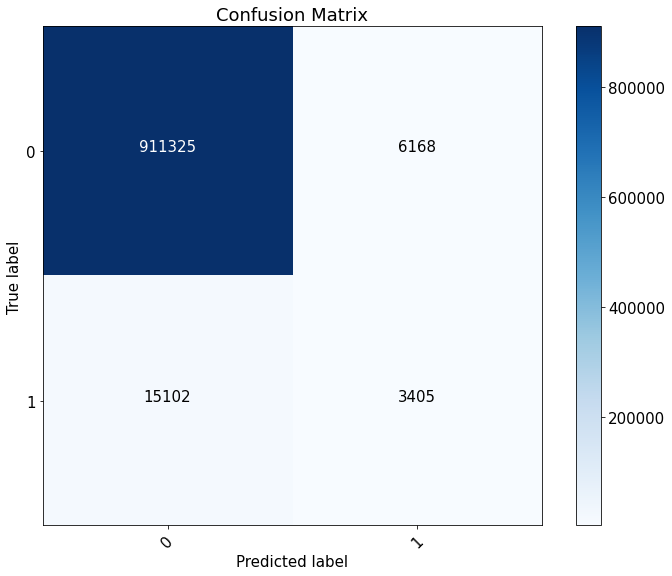

In [53]:
font = {'size': 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(X_train.target, lr_predict_7 > th)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=[0, 1], title='Confusion Matrix')

In [54]:
rf_7 = RandomForestClassifier(class_weight='balanced', oob_score=True, n_jobs=-1)

In [55]:
%%time
rf_7.fit(X_train_all_feat_7, X_train.target)

rf_predict_7 = rf_7.predict_proba(X_train_all_feat_7)[:, 1]

roc_auc, prec, rec, f_score, th = get_metrics(X_train.target, rf_predict_7)
print(f'roc_auc: {roc_auc:.4f}, prec: {prec:.4f}, rec: {rec:.4f},'
      f' f-score: {f_score:.4f}, th: {th:.4f}')

roc_auc: 1.0000, prec: 0.9997, rec: 1.0000, f-score: 0.9998, th: 0.4400
Wall time: 3min 43s


In [56]:
oob_pred_train_7 = rf_7.oob_decision_function_[:, 1]

roc_auc, prec, rec, f_score, th = get_metrics(X_train.target, oob_pred_train_7)
print(f'roc_auc: {roc_auc:.4f}, prec: {prec:.4f}, rec: {rec:.4f},'
      f' f-score: {f_score:.4f}, th: {th:.4f}')

roc_auc: 0.7071, prec: 0.4793, rec: 0.1874, f-score: 0.2694, th: 0.1892


Confusion matrix, without normalization
[[913836   3657]
 [ 15061   3446]]


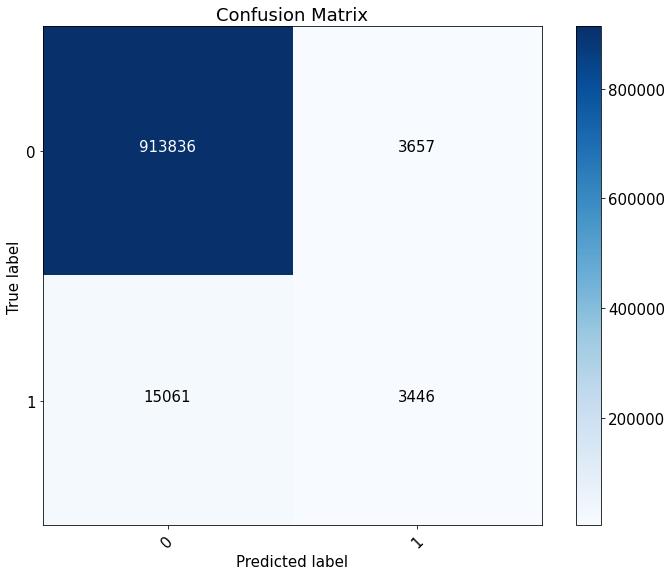

In [57]:
cnf_matrix_rf = confusion_matrix(X_train.target, oob_pred_train_7 > th)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_rf, classes=[0, 1], title='Confusion Matrix')

начали с:

lr:

        roc_auc: 0.7614, prec: 0.3735, rec: 0.1814, f-score: 0.2442, th: 0.8565
        
rf:

        на трейне - заметно переобучен:
        roc_auc: 1.0000, prec: 0.9997, rec: 1.0000, f-score: 0.9999, th: 0.4300
        oob-score: 
        roc_auc: 0.7076, prec: 0.4307, rec: 0.1957, f-score: 0.2691, th: 0.1750


- пришли к:

lr_6:

        roc_auc: 0.7644, prec: 0.3558, rec: 0.1840, f-score: 0.2426, th: 0.8575

rf_6 oob:

        roc_auc: 0.7071, prec: 0.4793, rec: 0.1874, f-score: 0.2694, th: 0.1892

- потенциал есть + как опора для предварительного отбора даже с простыми моделями
- + если подобрать нужный $\beta$-коэф-т для f-score...

- **lgbm**

In [112]:
metrics_df = pd.DataFrame({'roc-auc': [], 'prec': [], 'rec': [], 'f-score': [], 'th': []})

In [26]:
%%time
lgb1 = LGBMClassifier(objective='binary', max_depth=7, 
                     class_weight='balanced',
                     subsample=0.8,
                     random_state=42,
                     n_jobs=-1
                    )
lgb1.fit(X_train_all_feat_7, X_train.target)

Wall time: 17.3 s


LGBMClassifier(class_weight='balanced', max_depth=7, objective='binary',
               random_state=42, subsample=0.8)

In [29]:
lgb_train_preds = lgb1.predict_proba(X_train_all_feat_7)[:, 1]

roc_auc, prec, rec, f_score, th = get_metrics(X_train.target, lgb_train_preds)
print(f'roc_auc: {roc_auc:.4f}, prec: {prec:.4f}, rec: {rec:.4f},'
      f' f-score: {f_score:.4f}, th: {th:.4f}')

roc_auc: 0.8339, prec: 0.3974, rec: 0.2316, f-score: 0.2926, th: 0.8370


In [117]:
metrics_df.loc['lgb'] = [roc_auc, prec, rec, f_score, th]
metrics_df

,roc-auc,prec,rec,f-score,th
lgb,0.833944,0.455865,0.213757,0.291043,0.861212


Confusion matrix, without normalization
[[912771   4722]
 [ 14552   3955]]


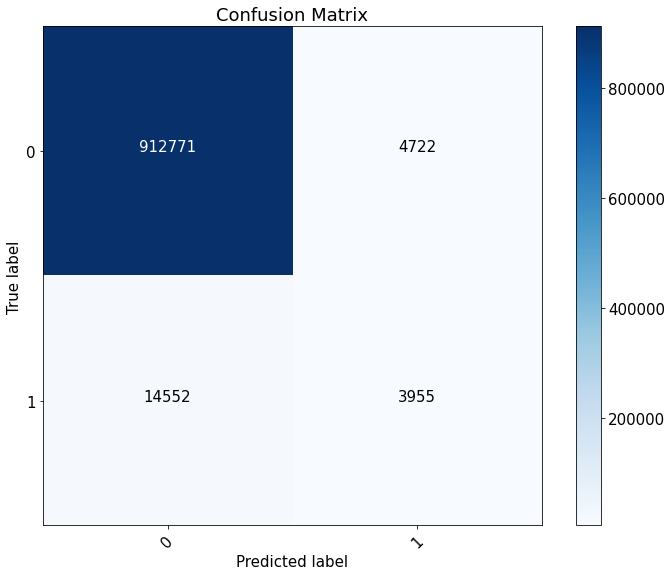

In [116]:
font = {'size': 15}

plt.rc('font', **font)

cnf_matrix_rf = confusion_matrix(X_train.target, lgb_train_preds > th)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_rf, classes=[0, 1], title='Confusion Matrix')

In [55]:
feats_imp = pd.DataFrame({'feat': lgb.feature_name_,
                          'importance': lgb.feature_importances_
                         })

feats_imp.sort_values('importance', ascending=False)[:20]

,feat,importance
261,from_registr_days_log,135
288,2021_2110,106
324,tax_arrears_log,102
276,2021_1520_q95,101
287,2020_1700_q95_growth,89
250,target_fract_per_region,85
272,2021_1150_q95,76
275,2021_1300_q95,67
357,n_employees,61
280,2020_1210_q95_growth,61


- **xgboost**

In [118]:
%%time
xgb1 = XGBClassifier(max_depth=7, 
                     subsample=0.8,
                     random_state=42,
                     n_jobs=-1
                    )
xgb1.fit(X_train_all_feat_7, X_train.target)

Wall time: 5min 48s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [119]:
xgb_train_preds = xgb1.predict_proba(X_train_all_feat_7)[:, 1]

roc_auc, prec, rec, f_score, th = get_metrics(X_train.target, xgb_train_preds)
print(f'roc_auc: {roc_auc:.4f}, prec: {prec:.4f}, rec: {rec:.4f},'
      f' f-score: {f_score:.4f}, th: {th:.4f}')

roc_auc: 0.9021, prec: 0.5965, rec: 0.3495, f-score: 0.4408, th: 0.1433


In [120]:
metrics_df.loc['xgb'] = [roc_auc, prec, rec, f_score, th]
metrics_df

,roc-auc,prec,rec,f-score,th
lgb,0.833944,0.455865,0.213757,0.291043,0.861212
xgb,0.902146,0.596496,0.349543,0.440788,0.143275


Confusion matrix, without normalization
[[913117   4376]
 [ 12039   6468]]


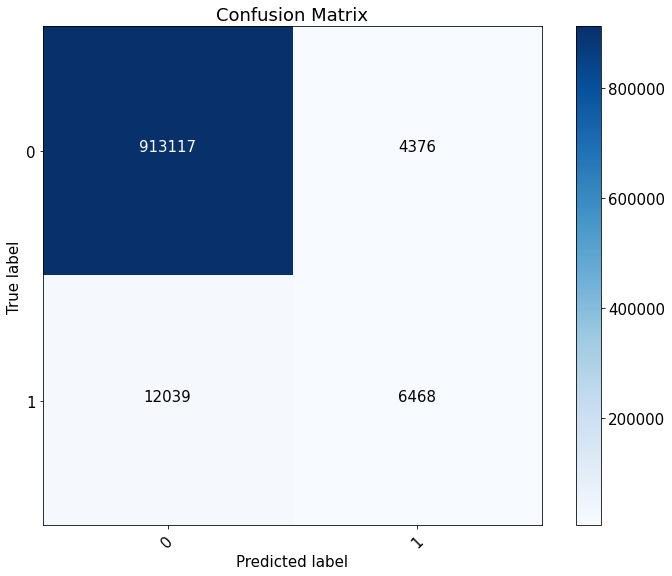

In [121]:
font = {'size': 15}

plt.rc('font', **font)

cnf_matrix_rf = confusion_matrix(X_train.target, xgb_train_preds > th)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_rf, classes=[0, 1], title='Confusion Matrix')

- у lgbm неплохая метрика на трейне
- xgb скорее всего тоже переобучен
- но нужно посмотреть валидацию
- lgbm работает очень быстро

In [78]:
params = {
    'max_depth': [5, 7, 9],
    'n_estimators': [50, 100, 200],
    'class_weight': ['balanced'], 
    'subsample': [0.6, 0.8, 1] 
}

In [79]:
%%time
lgb = LGBMClassifier(objective='binary',
                    )

lgbm_gscv = GridSearchCV(estimator=lgb,
                         param_grid=params,
                         scoring=['roc_auc', 'precision', 'recall', 'f1'],
                         n_jobs=6,
                         cv=3,
                         refit='roc_auc',
                         verbose=True
                        )
lgbm_gscv.fit(X_train_all_feat_7, X_train.target)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Wall time: 13min 24s


GridSearchCV(cv=3, estimator=LGBMClassifier(objective='binary'), n_jobs=6,
             param_grid={'class_weight': ['balanced'], 'max_depth': [5, 7, 9],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.6, 0.8, 1]},
             refit='roc_auc', scoring=['roc_auc', 'precision', 'recall', 'f1'],
             verbose=True)

In [58]:
# lgbm_gscv.cv_results_

LGBMClassifier(class_weight='balanced', max_depth=7, objective='binary', subsample=0.6)

'n_estimators': 100,

In [81]:
lgbm_gscv.best_estimator_

LGBMClassifier(class_weight='balanced', max_depth=7, objective='binary',
               subsample=0.6)

In [85]:
lgbm_gscv.best_score_

0.7980591878421569

In [122]:
lgbm_metrics = []
for key in ['mean_test_roc_auc', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']:
    print(key, lgbm_gscv.cv_results_[key][lgbm_gscv.best_index_])
    lgbm_metrics.append(lgbm_gscv.cv_results_[key][lgbm_gscv.best_index_])
    
    
print('std_test_roc_auc', lgbm_gscv.cv_results_['std_test_roc_auc'][lgbm_gscv.best_index_])
lgbm_metrics.append(None)

mean_test_roc_auc 0.7980591878421569
mean_test_precision 0.04983357702406858
mean_test_recall 0.6966553196087967
mean_test_f1 0.0930130393044931
std_test_roc_auc 0.0035939966258005307


In [125]:
metrics_df.loc['lgb_cv_valid_mean'] = lgbm_metrics
metrics_df

,roc-auc,prec,rec,f-score,th
lgb,0.833944,0.455865,0.213757,0.291043,0.861212
xgb,0.902146,0.596496,0.349543,0.440788,0.143275
lgb_cv_valid_mean,0.798059,0.049834,0.696655,0.093013,NaN


- на трейне с лучшими гиперпараметрами

In [135]:
lgb_train_preds = lgbm_gscv.best_estimator_.predict_proba(X_train_all_feat_7)[:, 1]

roc_auc, prec, rec, f_score, th = get_metrics(X_train.target, lgb_train_preds)
print(f'roc_auc: {roc_auc:.4f}, prec: {prec:.4f}, rec: {rec:.4f},'
      f' f-score: {f_score:.4f}, th: {th:.4f}')

C:\Users\013\AppData\Local\Temp/ipykernel_7740/1415255493.py:4: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


roc_auc: 0.8346, prec: 0.4328, rec: 0.2211, f-score: 0.2926, th: 0.8527


In [136]:
metrics_df.loc['lgb_cv_train_mean'] = [roc_auc, prec, rec, f_score, th]
metrics_df

,roc-auc,prec,rec,f-score,th
lgb,0.833944,0.455865,0.213757,0.291043,0.861212
xgb,0.902146,0.596496,0.349543,0.440788,0.143275
lgb_cv_valid_mean,0.798059,0.049834,0.696655,0.093013,NaN
xgb_cv_valid_mean,0.793201,0.789404,0.129789,0.222923,NaN
xgb_cv_train_mean,0.826222,0.501693,0.232182,0.317450,0.138480
lgb_cv_train_mean,0.834626,0.432773,0.221051,0.292632,0.852732


Confusion matrix, without normalization
[[912131   5362]
 [ 14417   4090]]


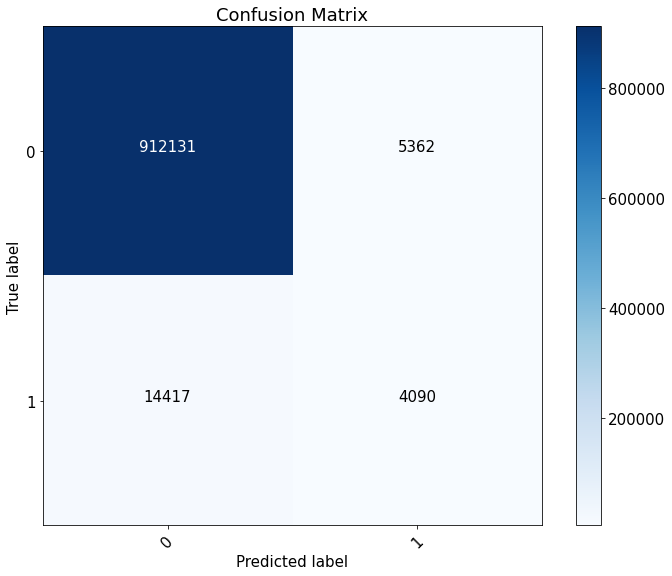

In [88]:
font = {'size': 15}

plt.rc('font', **font)

cnf_matrix_rf = confusion_matrix(X_train.target, lgb_train_preds > th)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_rf, classes=[0, 1], title='Confusion Matrix')

- поставим то же самое для xgbost

In [91]:
params = {
    'max_depth': [5, 7, 9],
    'n_estimators': [50, 100, 200],
    'subsample': [0.6, 0.8, 1] 
}

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Wall time: 6h 36min 17s

In [95]:
%%time
xgb = XGBClassifier()

xgb_gscv = GridSearchCV(estimator=xgb,
                         param_grid=params,
                         scoring=['roc_auc', 'precision', 'recall', 'f1'],
                         n_jobs=4,
                         cv=3,
                         refit='roc_auc',
                         verbose=3
                        )
xgb_gscv.fit(X_train_all_feat_7, X_train.target)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Wall time: 6h 36min 17s


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                        

max_depth=5, n_estimators=50, subsample=1

In [102]:
xgb_gscv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [131]:
xgb_metrics = []
for key in ['mean_test_roc_auc', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']:
    print(key, xgb_gscv.cv_results_[key][xgb_gscv.best_index_])
    xgb_metrics.append(xgb_gscv.cv_results_[key][xgb_gscv.best_index_])
    
    
print('std_test_roc_auc', xgb_gscv.cv_results_['std_test_roc_auc'][xgb_gscv.best_index_])
xgb_metrics.append(None)

mean_test_roc_auc 0.7932006778702995
mean_test_precision 0.7894043480481798
mean_test_recall 0.12978872858918247
mean_test_f1 0.22292308705064712
std_test_roc_auc 0.0031593075761821863


In [132]:
metrics_df.loc['xgb_cv_train'] = xgb_metrics
metrics_df

,roc-auc,prec,rec,f-score,th
lgb,0.833944,0.455865,0.213757,0.291043,0.861212
xgb,0.902146,0.596496,0.349543,0.440788,0.143275
lgb_cv_valid_mean,0.798059,0.049834,0.696655,0.093013,NaN
xgb_cv_valid_mean,0.793201,0.789404,0.129789,0.222923,NaN


- xgb_cv_valid_mean чуть хуже по roc-auc, но у него лучше остальные метрики (что там с порогом у cv?)

In [133]:
xgb_train_preds = xgb_gscv.best_estimator_.predict_proba(X_train_all_feat_7)[:, 1]

roc_auc, prec, rec, f_score, th = get_metrics(X_train.target, xgb_train_preds)
print(f'roc_auc: {roc_auc:.4f}, prec: {prec:.4f}, rec: {rec:.4f},'
      f' f-score: {f_score:.4f}, th: {th:.4f}')

roc_auc: 0.8262, prec: 0.5017, rec: 0.2322, f-score: 0.3174, th: 0.1385


In [134]:
metrics_df.loc['xgb_cv_train_mean'] = [roc_auc, prec, rec, f_score, th]
metrics_df

,roc-auc,prec,rec,f-score,th
lgb,0.833944,0.455865,0.213757,0.291043,0.861212
xgb,0.902146,0.596496,0.349543,0.440788,0.143275
lgb_cv_valid_mean,0.798059,0.049834,0.696655,0.093013,NaN
xgb_cv_valid_mean,0.793201,0.789404,0.129789,0.222923,NaN
xgb_cv_train_mean,0.826222,0.501693,0.232182,0.317450,0.138480


Confusion matrix, without normalization
[[913225   4268]
 [ 14211   4296]]


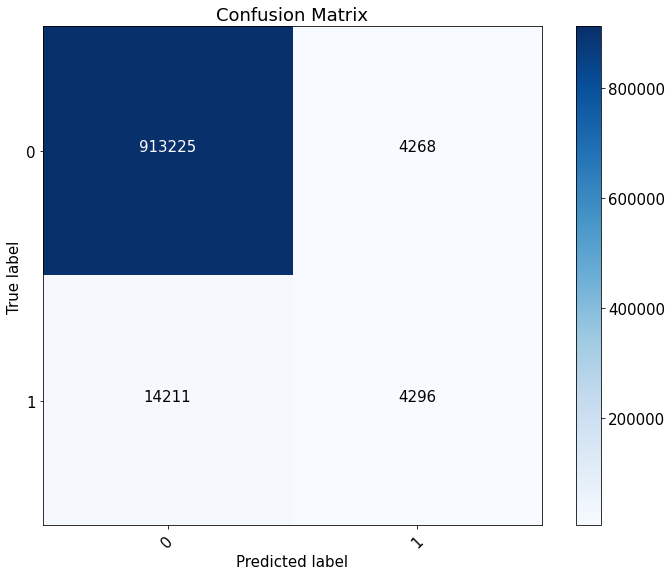

In [100]:
font = {'size': 15}

plt.rc('font', **font)

cnf_matrix_rf = confusion_matrix(X_train.target, xgb_train_preds > th)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_rf, classes=[0, 1], title='Confusion Matrix')

In [111]:
feats_imp_xgb = pd.DataFrame({'feat': xgb_gscv.best_estimator_.feature_names_in_,
                          'importance': xgb_gscv.best_estimator_.feature_importances_
                         })

feats_imp_xgb.sort_values('importance', ascending=False)[:20]

,feat,importance
319,arrears,0.084009
298,2021_2400_q95,0.059621
358,n_employees_med,0.032768
288,2021_2110,0.030175
275,2021_1300_q95,0.023805
300,2020_2110_q95_growth,0.020078
276,2021_1520_q95,0.019662
324,tax_arrears_log,0.019334
273,2021_1210_q95,0.018219
322,fines_log,0.017955


In [137]:
metrics_df

,roc-auc,prec,rec,f-score,th
lgb,0.833944,0.455865,0.213757,0.291043,0.861212
xgb,0.902146,0.596496,0.349543,0.440788,0.143275
lgb_cv_valid_mean,0.798059,0.049834,0.696655,0.093013,NaN
xgb_cv_valid_mean,0.793201,0.789404,0.129789,0.222923,NaN
xgb_cv_train_mean,0.826222,0.501693,0.232182,0.317450,0.138480
lgb_cv_train_mean,0.834626,0.432773,0.221051,0.292632,0.852732


- lgbm чуть лучше по roc-auc (и на трейне и на валидации) и заметно быстрее
- xgb немного переобучается на стандартных параметрах, чуть лучше по полноте и точности

In [138]:
# metrics_df.to_csv('../metrics.csv')

In [42]:
# metrics_df = pd.read_csv('../metrics.csv')